In [1]:
import sys, os
import logging
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from detectron2.engine import default_argument_parser
from detectron2.data import MetadataCatalog
from detectron2.modeling.poolers import ROIPooler
sys.path.insert(0, os.path.abspath("../../"))
from pgrcnn.data.dataset_mapper import JerseyNumberDatasetMapper
from pgrcnn.data.build import build_detection_train_loader
from pgrcnn.utils.custom_visualizer import JerseyNumberVisualizer
from pgrcnn.utils.launch_utils import setup
from pgrcnn.modeling.utils.gaussian_target import compute_targets
from pgrcnn.data.dataset_mapper import JerseyNumberDatasetMapper
logger = logging.getLogger("pgrcnn")
plt.rcParams["figure.figsize"] = (20,10)
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(18.5, 10.5)
# fig.savefig('test2png.png', dpi=100)

In [2]:
args = default_argument_parser().parse_args(args=["--config-file", "../../configs/pg_rcnn/tests/baseline.yaml"])
cfg = setup(args)
dataloader = build_detection_train_loader(cfg, mapper=JerseyNumberDatasetMapper(cfg, True))
mapper = JerseyNumberDatasetMapper(cfg, True)

[11/04 21:22:38 detectron2]: Rank of current process: 0. World size: 1
[11/04 21:22:38 detectron2]: Environment info:
---------------------  ----------------------------------------------------------------------------------
sys.platform           darwin
Python                 3.8.5 (default, Sep  4 2020, 02:22:02) [Clang 10.0.0 ]
numpy                  1.19.2
detectron2             0.5 @/Users/henry/Research/pgrcnn/detectron2/detectron2
Compiler               clang 12.0.5
CUDA compiler          not available
DETECTRON2_ENV_MODULE  <not set>
PyTorch                1.9.0 @/Users/henry/anaconda3/envs/pgrcnn/lib/python3.8/site-packages/torch
PyTorch debug build    False
GPU available          No: torch.cuda.is_available() == False
Pillow                 8.1.0
torchvision            0.10.0 @/Users/henry/anaconda3/envs/pgrcnn/lib/python3.8/site-packages/torchvision
fvcore                 0.1.5.post20210511
iopath                 0.1.8
cv2                    4.5.1
---------------------  -----

[11/04 21:22:38 detectron2]: Full config saved to ./output/pg_rcnn/tests/baseline/config.yaml
[11/04 21:22:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(480, 512, 544, 576, 608, 640), max_size=800, sample_style='choice')]
[11/04 21:22:39 pgrcnn.data.jerseynumbers]: Person box height: 324.87+-102.18
[11/04 21:22:39 pgrcnn.data.jerseynumbers]: Person box width: 139.77+-52.17
[11/04 21:22:39 pgrcnn.data.jerseynumbers]: Digit box height: 44.69+-12.62
[11/04 21:22:39 pgrcnn.data.jerseynumbers]: Digit box width: 22.01+-7.43
[11/04 21:22:39 pgrcnn.data.jerseynumbers]: Height digit / person bbox ratio: 0.13+-0.03
[11/04 21:22:39 pgrcnn.data.jerseynumbers]: Width digit / person bbox ratio: 0.15+-0.05
[11/04 21:22:39 d2.data.build]: Removed 0 images with no usable annotations. 1413 images left.
[11/04 21:22:39 pgrcnn.data.build]: Distribution of instances among all 111 categories:
|  category  | #instances   | category   | #ins

In [3]:
def visualize_training(batched_inputs, cfg):
    """
    A function used to visualize images and gts after any data augmentation
    used, the inputs here are the actual data fed into the model, so most of
    the fields are tensors.

    Modified from func visualize_training().

    Args:
        batched_inputs (list): a list that contains input to the model.

    """

    jnw_metadata = MetadataCatalog.get("jerseynumbers_train")
    batched_inputs = [batched_inputs[0]] if len(batched_inputs) > 1 else batched_inputs
    # assert len(batched_inputs) == 1, "visualize_training() needs batch size of 1"
    for input in batched_inputs:
        img = input["image"].cpu().numpy()
        assert img.shape[0] == 3, "Images should have 3 channels."
#         if cfg.INPUT.FORMAT == "RGB":
        img = img[::-1, :, :]
        img = img.transpose(1, 2, 0)
        v_gt = JerseyNumberVisualizer(img, metadata=jnw_metadata, scale=2)
        v_gt.draw_dataloader_instances(input)
        vis_img = v_gt.get_output()
        vis_img.save("test_image.pdf")
        return input['file_name'], vis_img.get_image()

def test_one_image(dataloader, show_data=False):
    sample_at = 140
    data = next(itertools.islice(dataloader, sample_at, None))
    logger.info(f"{data[0]['file_name']}")
    logger.info(f"{data[0]}")
    if show_data:
        file_name, vis_img = visualize_training(data, cfg)
#             vis_img = vis_img[:, :, ::-1]
        plt.imshow(vis_img)
    return data

[11/04 21:22:40 pgrcnn]: /Users/henry/Research/pgrcnn/datasets/jnw/total/U14-3_frame_20202_5.png
[11/04 21:22:40 pgrcnn]: {'image_id': 2294, 'file_name': '/Users/henry/Research/pgrcnn/datasets/jnw/total/U14-3_frame_20202_5.png', 'width': 252, 'height': 481, 'video_id': 3, 'image': tensor([[[117, 117, 117,  ..., 123, 123, 123],
         [117, 117, 117,  ..., 123, 123, 123],
         [117, 117, 117,  ..., 123, 123, 123],
         ...,
         [113, 113, 113,  ..., 121, 121, 121],
         [114, 114, 114,  ..., 120, 120, 120],
         [115, 115, 115,  ..., 119, 119, 119]],

        [[160, 160, 160,  ..., 163, 163, 163],
         [160, 160, 160,  ..., 163, 163, 163],
         [160, 160, 160,  ..., 163, 163, 163],
         ...,
         [149, 149, 149,  ..., 163, 163, 163],
         [148, 148, 148,  ..., 162, 162, 162],
         [148, 148, 148,  ..., 161, 161, 161]],

        [[140, 140, 140,  ..., 146, 146, 146],
         [140, 140, 140,  ..., 146, 146, 146],
         [140, 140, 140,  ..

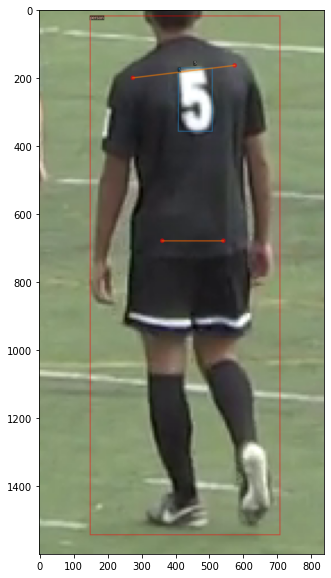

In [4]:
dataset_dict = test_one_image(dataloader, True)[0]

In [5]:
data = mapper(dataset_dict)
instances = data["instances"]

instances.proposal_boxes = instances.gt_boxes
N = len(instances.proposal_boxes)
K = 17
H = W = 512
instances.pred_keypoints_logits = torch.zeros((N, K, H, W))
targets = compute_targets(instances, (2, H, W), size_target_type="wh", size_target_scale="feature")

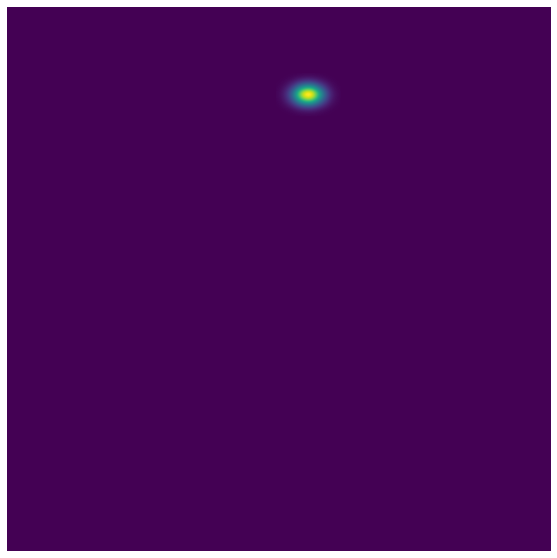

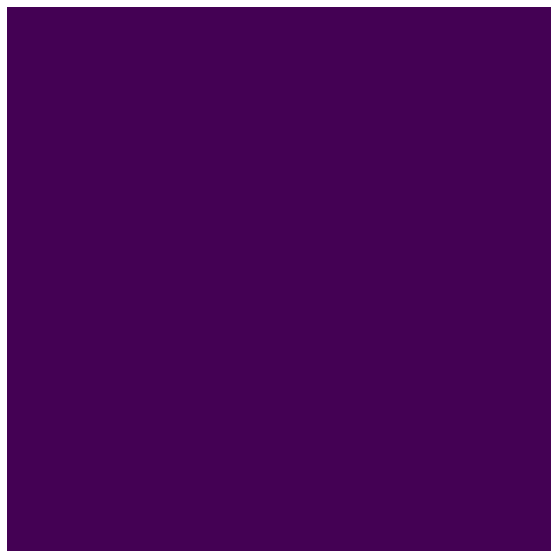

In [6]:
gt_center_heatmaps = targets[0][0].numpy()
for heatmap in gt_center_heatmaps:
    plt.figure()
    plt.axis('off')
    plt.imshow(heatmap)

In [7]:
pooler = ROIPooler((H, W), scales=[1.0], sampling_ratio=1, pooler_type="ROIAlignV2")
pooled_image_data = pooler([data['image'].unsqueeze(0).double()], [instances.proposal_boxes])
pooled_image_data = pooled_image_data[0].int().permute(1, 2, 0).numpy()
pooled_image_data = pooled_image_data[:, :, ::-1]

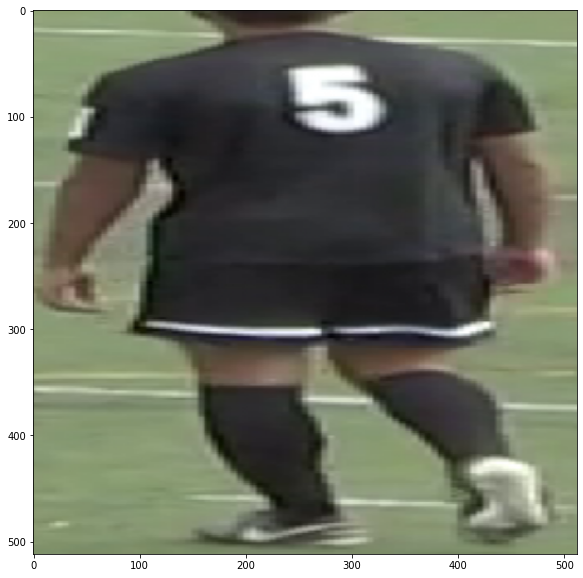

In [8]:
plt.imshow(pooled_image_data)

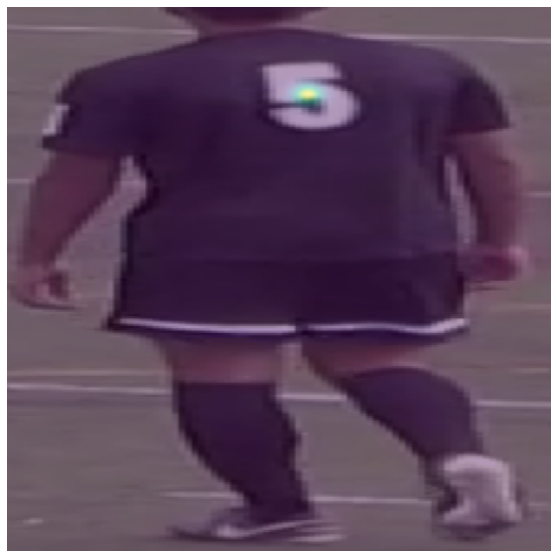

In [9]:
gt_center_heatmaps_combined = np.amax(gt_center_heatmaps, axis=0)
fig = plt.figure()
plt.imshow(gt_center_heatmaps_combined)
plt.imshow(pooled_image_data, cmap='jet', alpha=0.6)
plt.axis('off')
fig.savefig('heatmap_overlay.png', dpi=300)